In [1]:
import os
import ROOT as R

Welcome to JupyROOT 6.16/00


In [180]:
R.gROOT.SetBatch(True)
R.gStyle.SetOptStat(0)
R.gStyle.SetPadRightMargin(0.05)
R.gStyle.SetPadLeftMargin(0.12)
# R.gStyle.SetPadRightMargin(0.12)
R.gROOT.ForceStyle()

In [181]:
def plot_histos(config):
    """Plots histograms according to the configuration"""
    nCanv = len(config['histos'])
    for iC in range(nCanv):
        cHistos = config['histos'][iC]
        cColor = config['colors'][iC]
        cRange = config['range'][iC]
        cRebin = config['rebin'][iC]
        cOut = config['out'][iC]
        cSum = config['sum'][iC] if 'sum' in config else None
        # Reading histograms
        histos_ori = []
        for iH, hpath in enumerate(cHistos):
            file_path, hname = hpath.split(':')
            file_in = R.TFile(file_path)
            h = file_in.Get(hname).Clone('h{0:d}'.format(iH))
            h.Rebin(*cRebin)
            h.SetDirectory(0)
            R.SetOwnership(h, False)
            file_in.Close()
            histos_ori.append(h)
        # Summing histograms if required
        if not cSum:
            histos = histos_ori
        else:
            histos = []
            for iSum, sumList in enumerate(cSum):
                h = None
                for iH, hId in enumerate(sumList):
                    if iH == 0:
                        h = histos_ori[hId].Clone('hs{0:d}'.format(iSum))
                        h.SetDirectory(0)
                        R.SetOwnership(h, False)
                    else:
                        h.Add(histos_ori[iH])
                histos.append(h)
        # Applying normalisation
        if 'ynorm' in config:
            for iH, norm in enumerate(config['ynorm'][iC]):
                if norm is not None and iH < len(histos):
                    print(norm)
                    histos[iH].Scale(norm / histos[iH].GetMaximum())
        # Building legend
        leg = None
        if 'legends' in config:
            cLegend = config['legends'][iC]
            leg = R.TLegend(0.6, 0.9-len(histos)*0.05, 0.95, 0.9)
            leg.SetFillColor(10)
            leg.SetTextSize(0.04)
        # Drawing histograms
        C = R.TCanvas('C{0:d}'.format(iC), '', 800, 800)
        if 'logY' in config and config['logY']:
            C.SetLogy()
        if 'logZ' in config and config['logZ']:
            C.SetLogz()
        C.SetGridx()
        C.SetGridy()
        R.SetOwnership(C, False)
        for iH, h in enumerate(histos):
            h.SetLineWidth(2)
            h.SetLineColor(cColor[iH])
            if 'fill' in config and config['fill'][iH]:
                h.SetFillColor(cColor[iH])
            if 'line' in config:
                h.SetLineStyle(config['line'][iH])
            if leg:
                leg.AddEntry(h, cLegend[iH], 'l')
            drawOpt = 'HIST' if iH == 0 else 'HISTsame'
            if h.InheritsFrom('TH2'):
                drawOpt = 'colz'
            if iH == 0:
                h.GetXaxis().SetRangeUser(cRange[0][0], cRange[0][1])
                h.GetYaxis().SetRangeUser(cRange[1][0], cRange[1][1])
                h.GetYaxis().SetMaxDigits(3)
                if len(cRange) > 2:
                    h.GetZaxis().SetRangeUser(cRange[2][0], cRange[2][1])
            h.Draw(drawOpt)
        C.RedrawAxis("G")
        C.RedrawAxis()
        if leg:
            leg.Draw()
            R.SetOwnership(leg, False)
        C.Draw()
        C.SaveAs(cOut)

### Background hit properties

In [183]:
DIR_IN = '~/pdc/muoncdata/users/bartosik/clic/studies/2020_03_19_calo/plots'
FILE_IN = [os.path.join(DIR_IN, 'bkg_v2.root'), 
            os.path.join(DIR_IN, 'HitProps_pion_j1_v1.root'),
            os.path.join(DIR_IN, 'HitProps_photon_j1_v1.root'),
           ]
LEGENDS = ['BIB Photons', 'BIB Neutrons', 'Pion (10 GeV)', 'Photon (10GeV)']
# LEGENDS = ['Neutrons', 'Photons', 'All']
COLLECTIONS = [
    'ECalBarrelCollection', 'ECalEndcapCollection',
#     'HCalBarrelCollection', 'HCalEndcapCollection'
]
PRT_TYPES = [2,9]
COLORS = [R.kAzure+1, R.kOrange+8, 1, 1]

27000000.0
27000000.0
2700000.0
2700000.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: C0
Info in <TCanvas::Print>: pdf file /Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_03_19_calo/plots/hit_times/hit_time_by_mcp_ECalBarrelCollection.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: C1
Info in <TCanvas::Print>: pdf file /Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_03_19_calo/plots/hit_times/hit_time_by_mcp_ECalEndcapCollection.pdf has been created


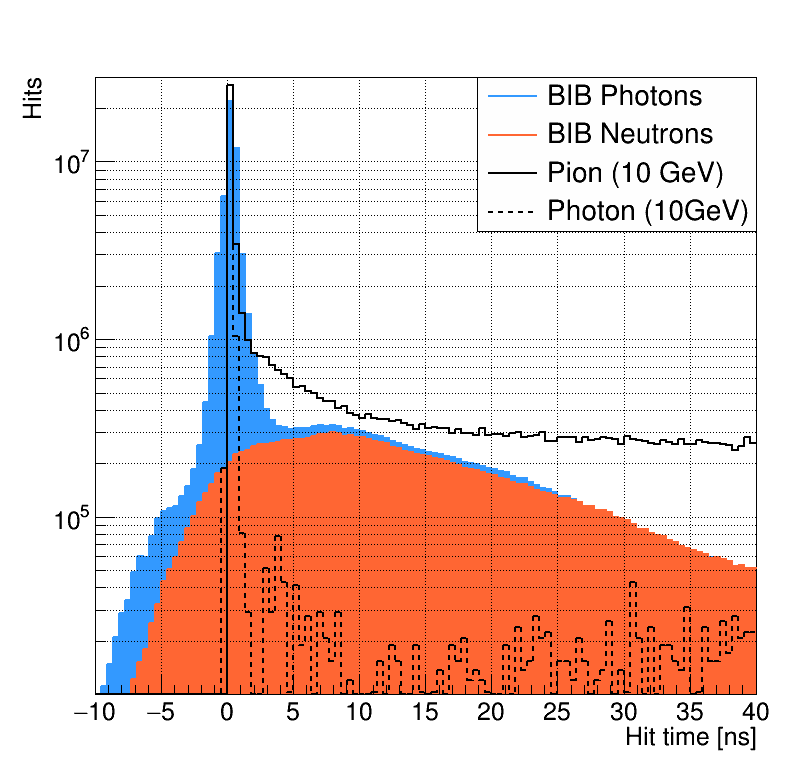

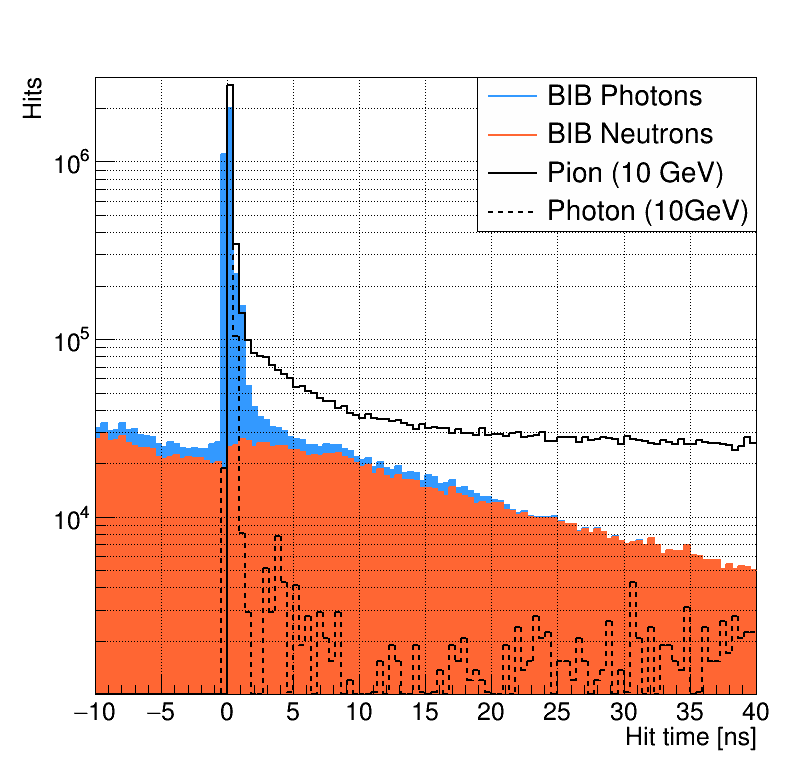

In [184]:
# hname = 'h_hit_time'
# hname = 'p_hit_e_vs_mcp_type'
# hname = 'p_hit_time_vs_mcp_type'
outname = 'hit_time_by_mcp'
hnames = ['h_hit_time_mcp_{0:d}'.format(prt) for prt in PRT_TYPES]
CONFIGS = {
    'histos': [
        [FILE_IN[0] + ':{0}_{1}'.format(hname, col) for hname in hnames] + [FILE_IN[i]+':h_hit_time_HCalBarrelCollection' for i in range(1,3)] for col in COLLECTIONS
    ],
    'sum': [[[0,1], [0], [2], [3]]]*len(COLLECTIONS),
    'legends': [LEGENDS]*len(COLLECTIONS),
    'colors': [COLORS]*len(COLLECTIONS),
    'fill': [1,1,0,0],
    'line': [1,1,1,7],
    'logY': True,
#     Full range
    'rebin': [[20]]*len(COLLECTIONS),
    'ynorm': [
        [None, None, 27e6, 27e6],
        [None, None, 27e5, 27e5],
#         [None, None, 13e4, 13e4],
#         [None, None, 43e3, 43e3],
    ],
#     'range': [ ((0, 25), (1, 5e6)) ]*len(COLLECTIONS),
#     'range': [ ((0, 25), (10, 1e3)) ]*len(COLLECTIONS),
    'range': [
        ((-10, 40), (1e4, 3e7)),
        ((-10, 40), (1e3, 3e6)),
#         ((-10, 40), (2e2, 14e4)),
#         ((-10, 40), (2e2, 5e4))
             ],
    'out': [os.path.join(DIR_IN, 'hit_times/{0}_{1}.pdf'.format(outname, col)) for col in COLLECTIONS]   
}
plot_histos(CONFIGS)

In [148]:
CONFIGS

{'histos': [['~/pdc/muoncdata/users/bartosik/clic/studies/2020_03_19_calo/plots/bkg_v2.root:h_hit_time_mcp_2_HCalBarrelCollection',
   '~/pdc/muoncdata/users/bartosik/clic/studies/2020_03_19_calo/plots/bkg_v2.root:h_hit_time_mcp_9_HCalBarrelCollection',
   '~/pdc/muoncdata/users/bartosik/clic/studies/2020_03_19_calo/plots/HitProps_pion_j1_v1.root:h_hit_time_HCalBarrelCollection',
   '~/pdc/muoncdata/users/bartosik/clic/studies/2020_03_19_calo/plots/HitProps_photon_j1_v1.root:h_hit_time_HCalBarrelCollection'],
  ['~/pdc/muoncdata/users/bartosik/clic/studies/2020_03_19_calo/plots/bkg_v2.root:h_hit_time_mcp_2_HCalEndcapCollection',
   '~/pdc/muoncdata/users/bartosik/clic/studies/2020_03_19_calo/plots/bkg_v2.root:h_hit_time_mcp_9_HCalEndcapCollection',
   '~/pdc/muoncdata/users/bartosik/clic/studies/2020_03_19_calo/plots/HitProps_pion_j1_v1.root:h_hit_time_HCalBarrelCollection',
   '~/pdc/muoncdata/users/bartosik/clic/studies/2020_03_19_calo/plots/HitProps_photon_j1_v1.root:h_hit_time_HCal

In [45]:
DIR_IN = '/Users/nbartosi/pdc/home/bartosik/clic/test4/mugun/v3_nobkg/plots'
FILES_IN = [os.path.join(DIR_IN, name) for name in ['base.root', 
                                                    'resT.root', 
                                                    'resT_cutT.root']]
LEGENDS = ['Default', 
           '+ #sigma_{t}', 
           '+ t < 3#sigma_{t}']
COLORS = [27, 2, R.kTeal+2, 1, 2]

### Hit timing

0 /Users/nbartosi/pdc/home/bartosik/clic/test4/mugun/v3_nobkg/plots/timing/vxd.pdf
1 /Users/nbartosi/pdc/home/bartosik/clic/test4/mugun/v3_nobkg/plots/timing/itk.pdf
2 /Users/nbartosi/pdc/home/bartosik/clic/test4/mugun/v3_nobkg/plots/timing/otk.pdf


Warning in <TCanvas::Constructor>: Deleting canvas with same name: C0
Info in <TCanvas::Print>: pdf file /Users/nbartosi/pdc/home/bartosik/clic/test4/mugun/v3_nobkg/plots/timing/vxd.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: C1
Info in <TCanvas::Print>: pdf file /Users/nbartosi/pdc/home/bartosik/clic/test4/mugun/v3_nobkg/plots/timing/itk.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: C2
Info in <TCanvas::Print>: pdf file /Users/nbartosi/pdc/home/bartosik/clic/test4/mugun/v3_nobkg/plots/timing/otk.pdf has been created


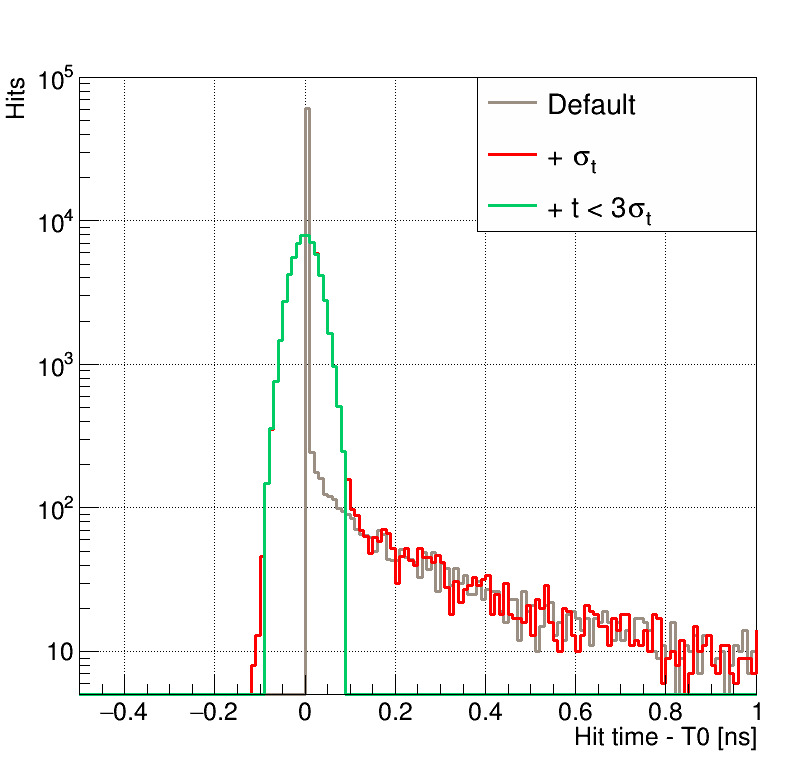

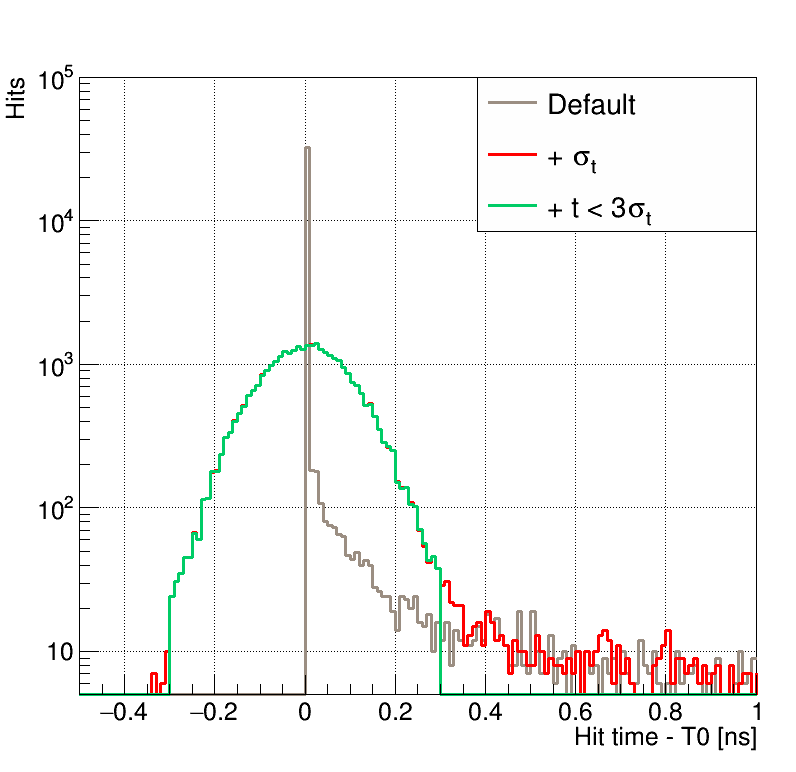

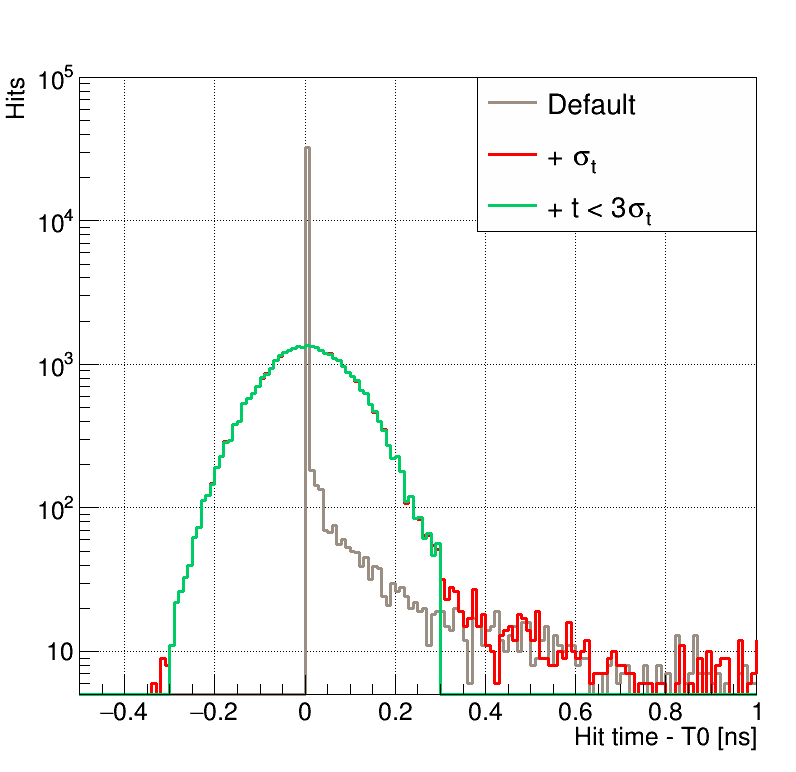

In [36]:
CONFIGS = {
    'histos': [
        [FILES_IN[i] + ':VXDTrackerHits_t_mt0' for i in range(3)],
        [FILES_IN[i] + ':ITrackerHits_t_mt0' for i in range(3)],
        [FILES_IN[i] + ':OTrackerHits_t_mt0' for i in range(3)],
    ],
    'legends': [LEGENDS]*3,
    'colors': [COLORS]*3,
    'logY': True,
#     Full range
    'rebin': [[1]]*3,
    'range': [
        ((-0.5, 1), (5, 1e5)), 
        ((-0.5, 1), (5, 1e5)), 
        ((-0.5, 1), (5, 1e5)), 
    ],
    'out': [
        os.path.join(DIR_IN, 'timing/vxd.pdf'),
        os.path.join(DIR_IN, 'timing/itk.pdf'),
        os.path.join(DIR_IN, 'timing/otk.pdf'),
    ]

}
plot_histos(CONFIGS)

In [28]:
import math

In [37]:
l = [11075,11383,10895,10738,10799,10961,11251,9457]
sum(l)/len(l)/3600

3.005520833333333